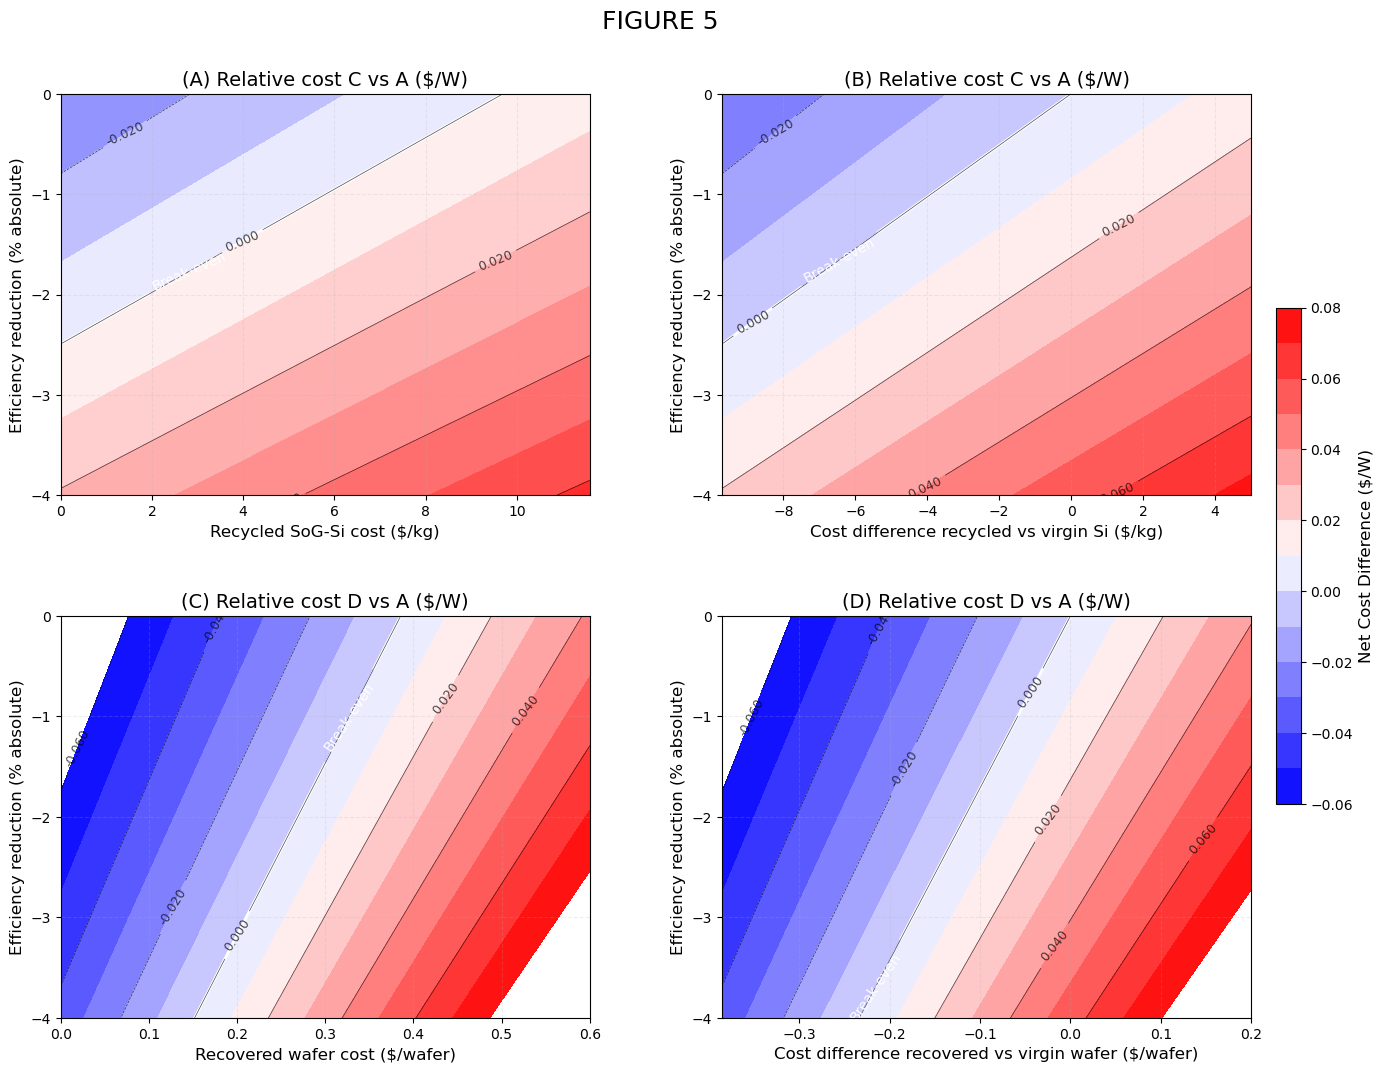

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Constants (from paper)
kg_per_wafer = 0.015  # kg/wafer
cells_per_module = 60
cell_area_m2 = 244e-4  # 244 cm² → 0.0244 m²
irradiance = 1000  # W/m² (STC)
CTM_ratio = 0.98
median_efficiency = 21.5  # %

# Calculate power constant
K = cells_per_module * irradiance * cell_area_m2 * CTM_ratio / 100    # W per % efficiency

# Median Costs (Table S1)
# Scenario A costs
C_mg_si = 2.5  # $/kg
C_sog_processing = 7.2  # $/kg
C_wafer_processing = 0.24  # $/wafer
C_cell_processing = 0.22  # $/cell
C_module_processing = 39.0  # $/module

# Compute total virgin costs
C_poly_si = C_mg_si + C_sog_processing  # $/kg
C_wafer_A = C_poly_si * kg_per_wafer + C_wafer_processing  # $/wafer
C_cell_A = C_wafer_A + C_cell_processing  # $/cell
C_module_A = cells_per_module * C_cell_A + C_module_processing  # $/module

# Power at median efficiency
P_A = K * median_efficiency    # Watts

# Cost functions for different scenarios
def cost_difference_C(recycled_cost, eff_reduction):
    """Scenario C vs A: Recycled SoG-Si"""
    # Compute Scenario C costs
    C_wafer_C = recycled_cost * kg_per_wafer + C_wafer_processing
    C_cell_C = C_wafer_C + C_cell_processing
    C_module_C = cells_per_module * C_cell_C + C_module_processing
    
    # Compute power with efficiency reduction
    efficiency_C = median_efficiency - eff_reduction
    P_C = K * efficiency_C
    
    # Cost per watt
    cpw_A = C_module_A / P_A
    cpw_C = C_module_C / P_C
    
    return cpw_C - cpw_A  # $/W difference

def cost_difference_D(recycled_cost, eff_reduction):
    """Scenario D vs A: Recovered Wafers"""
    # Compute Scenario D costs
    # Wafer cost is directly replaced
    C_wafer_D = recycled_cost  # $/wafer
    C_cell_D = C_wafer_D + C_cell_processing
    C_module_D = cells_per_module * C_cell_D + C_module_processing
    
    # Compute power with efficiency reduction
    efficiency_D = median_efficiency - eff_reduction
    P_D = K * efficiency_D
    
    # Cost per watt
    cpw_A = C_module_A / P_A
    cpw_D = C_module_D / P_D
    
    return cpw_D - cpw_A  # $/W difference
    
# Create colormap (similar to paper)
from matplotlib.colors import LinearSegmentedColormap

colors = ["blue", "white", "red"]  # Clean RGB
cmap = LinearSegmentedColormap.from_list("clean_bwr", colors, N=256)

from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=-0.06, vcenter=0, vmax=0.08)

# Create figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# =============================================
# Panel A: Scenario C vs A 
# =============================================
ax = axs[0, 0]
recycled_costs = np.linspace(0, 11.6, 100)  # $/kg
eff_reductions = np.linspace(0, 5, 100)  # % absolute
R, E = np.meshgrid(recycled_costs, eff_reductions)
Z = np.zeros_like(R)

for i in range(len(recycled_costs)):
    for j in range(len(eff_reductions)):
        Z[j,i] = cost_difference_C(R[j,i], E[j,i])

contour = ax.contourf(R, -E, Z, levels=np.linspace(-0.06, 0.08, 15), cmap=cmap, norm=norm)
zero_contour = ax.contour(R, -E, Z, levels=[0], colors='white', linewidths=2)
ax.clabel(zero_contour, inline=True, fmt="Break-even", fontsize=10)
contour_lines = ax.contour(R, -E, Z, levels=np.arange(-0.06, 0.07, 0.02), 
                           colors='k', linewidths=0.5, alpha=0.7)
ax.clabel(contour_lines, inline=True, fontsize=9, fmt="%.3f")

"""
ax.text(2, -0.5, 'C Cheaper', color='white', fontsize=12, fontweight='bold', ha='center')
ax.text(8, -3.5, 'A Cheaper', color='white', fontsize=12, fontweight='bold', ha='center')
"""

ax.set_xlabel("Recycled SoG-Si cost ($/kg)", fontsize=12)
ax.set_ylabel("Efficiency reduction (% absolute)", fontsize=12)
ax.set_title("(A) Relative cost C vs A ($/W)", fontsize=14)
ax.grid(alpha=0.2, linestyle='--')
ax.set_xlim(0, 11.6)
ax.set_ylim(-4, 0)
ax.set_yticks([0, -1, -2, -3, -4])


# =============================================
# Panel B: Scenario C vs A (Cost Difference)
# =============================================
ax = axs[0, 1]
virgin_sog_cost = C_poly_si  # $/kg
recycled_cost_diff = np.linspace(-virgin_sog_cost, 5, 100)  # Cost difference
eff_reductions = np.linspace(0, 5, 100)
R_diff, E = np.meshgrid(recycled_cost_diff, eff_reductions)
Z = np.zeros_like(R_diff)

for i in range(len(recycled_cost_diff)):
    for j in range(len(eff_reductions)):
        # Convert cost difference to absolute cost
        abs_cost = virgin_sog_cost + R_diff[j,i]
        Z[j,i] = cost_difference_C(abs_cost, E[j,i])

contour = ax.contourf(R_diff, -E, Z, levels=np.linspace(-0.06, 0.08, 15), cmap=cmap)
zero_contour = ax.contour(R_diff, -E, Z, levels=[0], colors='white', linewidths=2)
ax.clabel(zero_contour, inline=True, fmt="Break-even", fontsize=10)
contour_lines = ax.contour(R_diff, -E, Z, levels=np.arange(-0.06, 0.07, 0.02), 
                           colors='k', linewidths=0.5, alpha=0.7)
ax.clabel(contour_lines, inline=True, fontsize=9, fmt="%.3f")

"""
ax.text(-3, -0.5, 'C Cheaper', color='white', fontsize=12, fontweight='bold', ha='center')
ax.text(2, -3.5, 'A Cheaper', color='white', fontsize=12, fontweight='bold', ha='center')
"""

ax.set_xlabel("Cost difference recycled vs virgin Si ($/kg)", fontsize=12)
ax.set_ylabel("Efficiency reduction (% absolute)", fontsize=12)
ax.set_title("(B) Relative cost C vs A ($/W)", fontsize=14)
ax.grid(alpha=0.2, linestyle='--')
ax.set_xlim(-virgin_sog_cost, 5)
ax.set_ylim(-4, 0)
ax.set_yticks([0, -1, -2, -3, -4])

# =============================================
# Panel C: Scenario D vs A
# =============================================
ax = axs[1, 0]
virgin_wafer_cost = C_wafer_A  # $/wafer
recycled_costs = np.linspace(0, 0.6, 100)  # $/wafer (0 to $0.60)
eff_reductions = np.linspace(0, 5, 100)
R, E = np.meshgrid(recycled_costs, eff_reductions)
Z = np.zeros_like(R)

for i in range(len(recycled_costs)):
    for j in range(len(eff_reductions)):
        Z[j,i] = cost_difference_D(R[j,i], E[j,i])

contour = ax.contourf(R, -E, Z, levels=np.linspace(-0.06, 0.08, 15), cmap=cmap)
zero_contour = ax.contour(R, -E, Z, levels=[0], colors='white', linewidths=2)
ax.clabel(zero_contour, inline=True, fmt="Break-even", fontsize=10)
contour_lines = ax.contour(R, -E, Z, levels=np.arange(-0.06, 0.07, 0.02), 
                           colors='k', linewidths=0.5, alpha=0.7)
ax.clabel(contour_lines, inline=True, fontsize=9, fmt="%.3f")

"""
ax.text(0.1, -0.5, 'D Cheaper', color='white', fontsize=12, fontweight='bold', ha='center')
ax.text(0.4, -3.5, 'A Cheaper', color='white', fontsize=12, fontweight='bold', ha='center')
"""

ax.set_xlabel("Recovered wafer cost ($/wafer)", fontsize=12)
ax.set_ylabel("Efficiency reduction (% absolute)", fontsize=12)
ax.set_title("(C) Relative cost D vs A ($/W)", fontsize=14)
ax.grid(alpha=0.2, linestyle='--')
ax.set_xlim(0, 0.6)
ax.set_ylim(-4, 0)
ax.set_yticks([0, -1, -2, -3, -4])

# =============================================
# Panel D: Scenario D vs A (Cost Difference)
# =============================================
ax = axs[1, 1]
recycled_cost_diff = np.linspace(-virgin_wafer_cost, 0.2, 100)  # $/wafer
eff_reductions = np.linspace(0, 5, 100)
R_diff, E = np.meshgrid(recycled_cost_diff, eff_reductions)
Z = np.zeros_like(R_diff)

for i in range(len(recycled_cost_diff)):
    for j in range(len(eff_reductions)):
        # Convert cost difference to absolute cost
        abs_cost = virgin_wafer_cost + R_diff[j,i]
        Z[j,i] = cost_difference_D(abs_cost, E[j,i])

contour = ax.contourf(R_diff, -E, Z, levels=np.linspace(-0.06, 0.08, 15), cmap=cmap)
zero_contour = ax.contour(R_diff, -E, Z, levels=[0], colors='white', linewidths=2)
ax.clabel(zero_contour, inline=True, fmt="Break-even", fontsize=10)
contour_lines = ax.contour(R_diff, -E, Z, levels=np.arange(-0.06, 0.07, 0.02), 
                           colors='k', linewidths=0.5, alpha=0.7)
ax.clabel(contour_lines, inline=True, fontsize=9, fmt="%.3f")


"""
ax.text(-0.25, -0.5, 'D Cheaper', color='white', fontsize=12, fontweight='bold', ha='center')
ax.text(0.1, -3.5, 'A Cheaper', color='white', fontsize=12, fontweight='bold', ha='center')
"""

ax.set_xlabel("Cost difference recovered vs virgin wafer ($/wafer)", fontsize=12)
ax.set_ylabel("Efficiency reduction (% absolute)", fontsize=12)
ax.set_title("(D) Relative cost D vs A ($/W)", fontsize=14)
ax.grid(alpha=0.2, linestyle='--')
ax.set_xlim(-virgin_wafer_cost, 0.2)
ax.set_ylim(-4, 0)
ax.set_yticks([0, -1, -2, -3, -4])

# Add colorbar
cbar = fig.colorbar(contour, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label("Net Cost Difference ($/W)", fontsize=12)

# Add main title
fig.suptitle("FIGURE 5", 
             fontsize=18, y=0.95)

plt.savefig('deng_figure5.png', dpi=300, bbox_inches='tight')
plt.show()